In [128]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [129]:
train = pd.read_csv('~/Documents/AmesHousingML/clean_Data.csv') 

In [130]:
train

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NoAlley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBsmt,BsmtQual_Po,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NoBsmt,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondit

## Finding & Dealing with Outliers

In [131]:
train.shape

(2576, 266)

In [132]:
Q1 = train['SalePrice'].quantile(.25)
Q3 = train['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + 5 * IQR

In [133]:
before_outlier_total = train.count()[1]
train.drop(train[train['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train.count()[1]

In [134]:
train.shape

(2571, 266)

In [135]:
before_outlier_total - post_outlier_total

5

In [136]:
train.dtypes.value_counts()

float64    240
int64       26
dtype: int64

In [137]:
#train_numerics = train.select_dtypes(include=[np.number])

In [138]:
ft_train = train

Below is to create an object that will hold the categories of the one hot encoded variables into an easy way to add / remove the entire feature... Since features can be broken up into 5+ separate columns I needed an easy way to group and adjust the features as a whole.

In [139]:
# Create an empty dictionary to store dummy variables grouped by original categories
dummy_groups = {}

# Iterate through columns and group dummy variables by the original category
for column in ft_train.columns:
    category = column.split('_')[0] # Extract the original category from the column name
    if category not in dummy_groups:
        dummy_groups[category] = [column]
    else:
        dummy_groups[category].append(column)
    

    
# Convert the dictionary values to a list of lists
grouped_dummies = list(dummy_groups.values())

dummy_groups

{'PID': ['PID'],
 'GrLivArea': ['GrLivArea'],
 'SalePrice': ['SalePrice'],
 'MSSubClass': ['MSSubClass'],
 'LotFrontage': ['LotFrontage'],
 'LotArea': ['LotArea'],
 'OverallQual': ['OverallQual'],
 'OverallCond': ['OverallCond'],
 'YearBuilt': ['YearBuilt'],
 'YearRemodAdd': ['YearRemodAdd'],
 'MasVnrArea': ['MasVnrArea'],
 'BsmtFinSF1': ['BsmtFinSF1'],
 'BsmtFinSF2': ['BsmtFinSF2'],
 'BsmtUnfSF': ['BsmtUnfSF'],
 'TotalBsmtSF': ['TotalBsmtSF'],
 '1stFlrSF': ['1stFlrSF'],
 '2ndFlrSF': ['2ndFlrSF'],
 'LowQualFinSF': ['LowQualFinSF'],
 'BsmtFullBath': ['BsmtFullBath'],
 'BsmtHalfBath': ['BsmtHalfBath'],
 'FullBath': ['FullBath'],
 'HalfBath': ['HalfBath'],
 'BedroomAbvGr': ['BedroomAbvGr'],
 'KitchenAbvGr': ['KitchenAbvGr'],
 'TotRmsAbvGrd': ['TotRmsAbvGrd'],
 'Fireplaces': ['Fireplaces'],
 'GarageYrBlt': ['GarageYrBlt'],
 'GarageCars': ['GarageCars'],
 'GarageArea': ['GarageArea'],
 'WoodDeckSF': ['WoodDeckSF'],
 'OpenPorchSF': ['OpenPorchSF'],
 'EnclosedPorch': ['EnclosedPorch'],
 '3Ssn

In [216]:
dummy_groups.keys()


dict_keys(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'Gar

In [331]:
print(grouped_dummies[44])
print(grouped_dummies[54])
print(grouped_dummies[57])
print(grouped_dummies[59])
print(grouped_dummies[66])

['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']
['ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA']
['BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_NoBsmt', 'BsmtQual_Po', 'BsmtQual_TA']
['BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_NoBsmt']
['KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_Po', 'KitchenQual_TA']


Now I want to grab a list of all the values in the dictionary and use that as a check list of sorts to start finding the optimal model in linear regression

In [140]:
train.head()

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NoAlley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBsmt,BsmtQual_Po,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NoBsmt,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondit

0 PID - no relevance  
1 GrLivArea -  Base .51   **  
2 SalePrice - needed, our target   ***  
3 MSSubClass - .018 Low, but add for now  **    
4 LotFrontage - .004 VERY LOW not adding  
5 LotArea - .004 VERY LOW not adding  
6 OverallQual - .231 VERY HIGH adding  **  
7 OverallCond - .000> VERY LOW not adding  
8 YearBuilt - .029 Low, but add for now  **  
9 YearRemodAdd - .002 VERY LOW not adding  
10 MasVnrArea - .008 VERY LOW not adding  
11 BsmtFinSF1 - .039, Low but add for now **  
12 BsmtFinSF2 - .002 VERY LOW not adding  
13 BsmtUnfSF - .002 VERY LOW not adding  
14 TotalBsmtSF - .006 VERY LOW not adding  
15 1stFlrSF - .005 VERY LOW not adding  
16 2ndFlrSF - .005 VERY LOW not adding  
17 LowQualFinSF - .000> VERY LOW not adding  
18 BsmtFullBath - .001   
19 BsmtHalfBath - .000>    
20 FullBath - .000>    
21 HalfBath .001    
22 BedroomAbvGr .008   
23 KitchenAbvGr .001  
24 TotRmsAbvGrd .000>    
25 Fireplaces .002 VERY LOW    
26 GarageYrBlt .000>     
27 GarageCars .005     
28 GarageArea .008      
29 .002   
30 .000>  
31 .000>  
still .831   
32 - .000>   
33 - .001>   
34 - .000>   
36 0.0005081924875021127  
37 0.00017229000596796773  
38 8.138173810900984e-05  
39 0.0011690477277823685  
40 0.004123684222936963  
41 -3.7745744698725048e-06  
42 0.0009461764132255857  
43 0.0022236108402915455  
44 0.037197461844858615  
45 0.0021357289206390684  
46 0.0022272980159636635  
47 0.0037434430570579824  
48 0.004807917477685053  
49 0.0024011022980201524  
50 0.001185153895471247  
51 0.006327896456015059  
52 0.005585689826793749  
53 0.0014866488580778103  
54 0.02277149578521631  
55 0.0007166449471727177  
56 0.0028372501147040374  
57 0.020281531861389923  
58 0.0005105942073936331  
59 0.01174770715075879  
60 0.002619241294328001  
61 0.002996191071345078  
62 0.0012503048840082354  
63 0.003939414563802757  
64 7.095301196435866e-05  
65 8.855140213115398e-05  
66 0.02239194395740063  
67 0.001063376375202374  
68 0.008847482980904098  
69 0.000333294955161767  
70 0.0014911966585295922  
71 0.0014370454327499171  
72 0.00011716981624554368  
73 0.0007731350633617406  
74 0.000348025947278896  
75 0.006283484958387153   
76 0.007262986856483522   
did these with the .831   
77 TotalHouseSF - .006  
78 TotalBathroomCount - no bueno  
79 -003   
80 -004   
81 -005  
82 - .006  
83 - .002  
84 - .001  
85 - .000>  

^ above was for the .831 model, continuing to improve 
adjusting the function for the current improvement


In [304]:
rScoreStorage = {}

In [366]:
def regression_tester(dict_index):
    #input the index of the columns that 
    colsTrackerTest = [2, 1, 3, 6, 8, 11, 44, 54, 59, 7, dict_index]
    included_colsTest = []
    for col in colsTrackerTest:
        included_colsTest.extend(grouped_dummies[col])

    ft_trainTest = train[included_colsTest]

    #the features will be X (independent variables)
    Xtest = ft_trainTest.drop('SalePrice', axis=1)
    X_arrayTest = Xtest.values
    #the target (dependent variable) will be y
    ytest = ft_trainTest['SalePrice']
    y_arrayTest = ytest.values


    # Perform linear regression using scikit-learn
    modeltest = LinearRegression()
    modeltest.fit(Xtest, ytest)



    # Make predictions using the trained model
    predictionsTest = modeltest.predict(Xtest)

    
    # Rsquared value
    #print("R Squared on the test set:", r2_score(ytest, predictionsTest))
    
    rScoreStorage[dict_index] = r2_score(ytest, predictionsTest)
    
    




In [378]:
#test the indexes of the dataset in LinearRegression 
# for this current given model and store the results:
for i in range(1,86):
    regression_tester(i)

In [385]:
#adjust this for the current model
for i in rScoreStorage:
    print(i, rScoreStorage[i] - 0.8998169885597271)


36 -0.0034571329201225076
37 -0.004295549335917803
38 -0.004241951221197415
39 -0.0034780990946311485
40 -0.0040800540496549464
41 -0.0042982310553918435
42 -0.0035752926748729985
43 -0.004171892064398164
44 -0.004298232835881488
45 -0.0030959905825690415
46 -0.0008029572884448166
47 -0.0010383754128652223
48 -0.0031489172656130604
49 -0.0037476134188512145
50 -0.0030442360303475358
51 -0.0011998193841529226
52 -0.0017083607044431348
53 -0.004261349741558229
54 -0.004298232835881599
55 -0.0042588393084048715
56 -0.0034023143514880783
57 0.0
58 -0.004223179803665933
59 -0.004298232835881599
60 -0.0037984616132411553
61 -0.0030464245695622783
62 -0.003610456309140586
63 -0.003399418867508497
64 -0.004276997139530558
65 -0.004216418524812027
66 -0.0004775614717671406
67 -0.003236534535734026
68 -0.0020911992363480403
69 -0.004038816333486239
70 -0.00344931836900364
71 -0.0030344380795748194
72 -0.004198621823197857
73 -0.004222624172270706
74 -0.004219865740846984
75 -0.002329178522945563

In [386]:
#adjust this for the current model and the values you want to include
for i in rScoreStorage:
    if (rScoreStorage[i] - 0.8998169885597271 > .000):
        print(i)

I will try and keep track of what R2 is added with what category of variables included... 

In [183]:
oldr2 = 0
oldmse = 0
oldrmse = 0

In [376]:
#input the index of the columns that 
colsTracker = [2, 1, 3, 6, 8, 11, 44, 54, 59, 7, 57]
included_cols = []
for col in colsTracker:
    included_cols.extend(grouped_dummies[col])
    
ft_train = train[included_cols]

#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = ft_train['SalePrice']
y_array = y.values


# Perform linear regression using scikit-learn
model = LinearRegression()
model.fit(X, y)

X_with_intercept = sm.add_constant(X)  # Add intercept term
model_sm = sm.OLS(y,X_with_intercept).fit()

# Make predictions using the trained model
predictions = model.predict(X)


# Rsquared value
print("R Squared on the test set:", r2_score(y, predictions))
print('R Square Change: ', r2_score(y, predictions) - oldr2)

#if inputting new values it will tell you the change
oldr2 = r2_score(y,predictions)

# Mean Squared Error (MSE) on the test set

print("Mean Squared Error (MSE) on the test set:", mean_squared_error(y, predictions))
print('Mean Squared Error (MSE) Change: ', mean_squared_error(y, predictions) - oldmse)

oldmse = mean_squared_error(y, predictions)

# Root Mean Squared Error (RMSE) on the test set

print("Root Mean Squared Error (RMSE) on the test set:", mean_squared_error(y, predictions, squared=False))
print('Root Mean Squared Error (RMSE) Change: ', mean_squared_error(y, predictions, squared=False) - oldrmse)

oldrmse = mean_squared_error(y, predictions, squared=False)

print(model_sm.summary())


R Squared on the test set: 0.8998169885597271
R Square Change:  0.0
Mean Squared Error (MSE) on the test set: 521786629.0984221
Mean Squared Error (MSE) Change:  0.0
Root Mean Squared Error (RMSE) on the test set: 22842.649344995472
Root Mean Squared Error (RMSE) Change:  0.0
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     527.8
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:55:30   Log-Likelihood:                -29452.
No. Observations:                2571   AIC:                         5.899e+04
Df Residuals:                    2527   BIC:                         5.925e+04
Df Model:                          43                                         
Covariance T

In [143]:
# #start a list to keep track of what we want to keep out of our top 10
# columns_to_exclude = ['EnclosedPorch', 'Alley_NoAlley', 'LotShape_IR2',
#                         'LotConfig_CulDSac', 'Neighborhood_BrDale', 'Neighborhood_MeadowV',
#                         'Neighborhood_Sawyer', 'Neighborhood_Timber', 'Neighborhood_Veenker',
#                         'Condition1_Feedr', 'Exterior2nd_MetalSd', 'ExterQual_Fa', 
#                         'ExterCond_TA', 'Foundation_CBlock', 'BsmtFinType1_BLQ', 
#                         'CentralAir_Y', 'Electrical_FuseF', 'GarageType_BuiltIn',
#                         'GarageCond_TA', 'BsmtUnfSF', 'BsmtCond_Fa', 'GarageQual_Fa',
#                       'BldgType_2fmCon', 'BldgType_Twnhs',# just added bsmt, lowered VIF but lowered R2
#                       'MSZoning_FV', 'Neighborhood_Somerst', 'HeatingQC_Gd',
#                       'MSZoning_C (all)', 'Condition1_PosN', 'ExterCond_Fa', 'BsmtCond_TA',
#                         'HeatingQC_Fa', 'SaleType_WD ', 'MSZoning_RH', 'KitchenAbvGr', 'LotConfig_Inside', 'LandSlope_Mod',
# 'Exterior1st_CemntBd', 'Exterior2nd_HdBoard',
#                       'Fence_NoFence', 'FireplaceQu_TA', 'KitchenQual_Fa', 'BsmtFinType2_NoBsmt',
#                       'BsmtQual_TA', 'BsmtExposure_NoBsmt', 'BsmtQual_Fa', 'GarageCond_Fa', 'Fence_MnPrv',
#                       'Exterior1st_MetalSd', 'Neighborhood_IDOTRR', 'LotShape_Reg', 'BsmtFinSF1',
#                       'BsmtQual_NoBsmt', 'BsmtCond_NoBsmt', 'BsmtFinType1_NoBsmt', 
#                       'PID', 'MSZoning_RL', 'NonHouseSF', 'RoofStyle_Hip', 'OpenPorchSF', 'RoofStyle_Gable',
#                       'WoodDeckSF', 'TotRmsAbvGrd','Neighborhood_OldTown', 
#                       'MasVnrType_BrkFace', 'Electrical_SBrkr',
#                       'GarageType_Attchd', 'GarageType_NoGarage', 'PavedDrive_Y',
#                       'MasVnrType_Stone', 'SaleType_New', 
#                       'GarageFinish_NoGarage', 'GarageQual_NoGarage', 'GarageCond_NoGarage',
#                       'MasVnrType_Stone','GarageYrBlt', 'Exterior2nd_VinylSd',
#                       'GarageType_Detchd','Foundation_PConc','BsmtFinType1_GLQ',
#                       'HighQualFinSF', 'Exterior1st_VinylSd','GarageFinish_Unf', 
#                       'KitchenQual_Gd', 'KitchenQual_TA','Fireplaces','ExterQual_Gd',
#                       'TotalBathroomCount','FireplaceQu_NoFireplace','GrLivArea',
#                       'ExterQual_TA','YearBuilt','YearRemodAdd','GarageCars','1stFlrSF', 
#                       '2ndFlrSF','TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath', 
#                       'FullBath','HalfBath']
# #'BsmtFinType1_GLQ', 'BsmtFinType1_GLQ', 'HighQualFinSF','Exterior1st_VinylSd', 'Foundation_PConc', 
# #create those into a numerics df alongside a correlation matrix
# ft_numerics = train_numerics.drop(columns=columns_to_exclude)
# ft_corr = ft_numerics.corr()


# # heatmap = sns.heatmap(ft_numerics[ft_corr['SalePrice'].nlargest(11).index].corr(), annot=True,annot_kws={"size": 25})  
# # heatmap
# # sns.set(rc={'figure.figsize':(25,25)})
# # plt.yticks(rotation=0, fontsize=25)  # Adjust font size for y-axis labels
# # plt.xticks(rotation=45, fontsize=25)  # Adjust font size for x-axis labels

# #code to run before modeling, in multiple areas

# train_numerics.drop(columns=columns_to_exclude)
# train_corr = train_numerics.corr()

# find_SPVIFer = abs(train_corr['SalePrice']) > 0.12
# condition = abs(train_corr['SalePrice']) > 0.05
# columns_abv_threshold = train_corr.columns[condition].tolist()
# filtered_list = list(filter(lambda x: x not in columns_to_exclude, columns_abv_threshold))
# columns_abv_threshold = filtered_list


# abv_threshold_corr = train[columns_abv_threshold].corr()
# ft_train = train[columns_abv_threshold]

ALL VIF CHECKER:

In [377]:
predictors = [col for col in ft_train.columns if col != 'SalePrice']

target = "SalePrice"

#subset the dataframe with these to test
subset_train = train[predictors + [target]]

#add a constant column for intercept
subset_train = add_constant(subset_train)

# Calculate VIF for the predictor variables
vif_table = pd.DataFrame()
vif_table['Variables'] = subset_train.columns
vif_table['VIF'] = [variance_inflation_factor(subset_train.values, i) for i in range(subset_train.shape[1])]
vifTable = vif_table[vif_table['Variables'].isin(predictors)]
# Display the VIF DataFrame for 'ab' and 'ac'
#print(vif_Garage[vif_Garage['Variables'].isin(predictors)])
vifTable[vifTable['VIF'] > 5]

,Variables,VIF
4,YearBuilt,6.345560
8,Neighborhood_BrkSide,6.603648
10,Neighborhood_CollgCr,10.705255
11,Neighborhood_Crawfor,5.707240
12,Neighborhood_Edwards,8.975625
13,Neighborhood_Gilbert,7.169872
15,Neighborhood_IDOTRR,5.305355
17,Neighborhood_Mitchel,5.840461
18,Neighborhood_NAmes,18.919452
20,Neighborhood_NWAmes,6.800489


# Model Building

Let's start with a simple linear regression on the basic numeric variables we got after making one feature and clearing some multicollinearity.

R Squared on the test set: 0.8175079052749366
Mean Squared Error (MSE) on the test set: 950479862.5510502
Root Mean Squared Error (RMSE) on the test set: 30829.85343058008


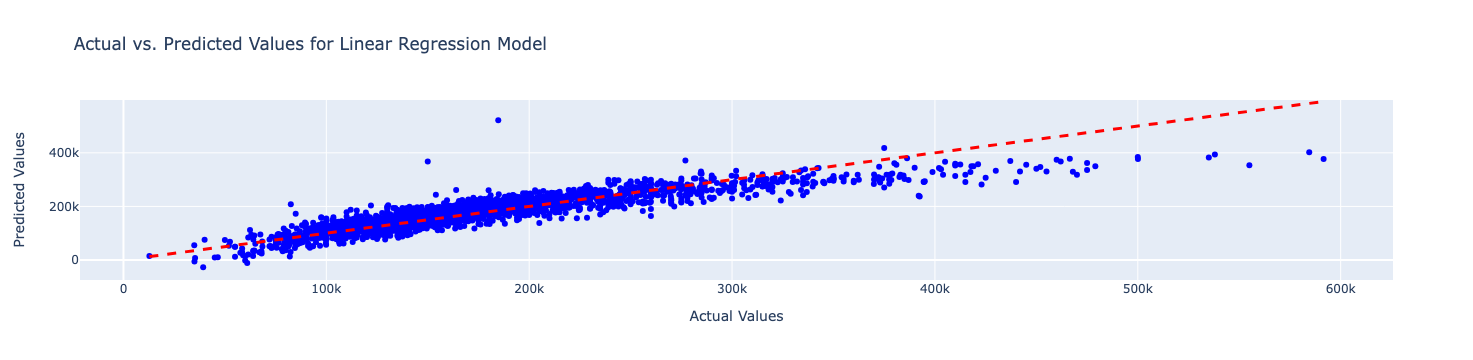

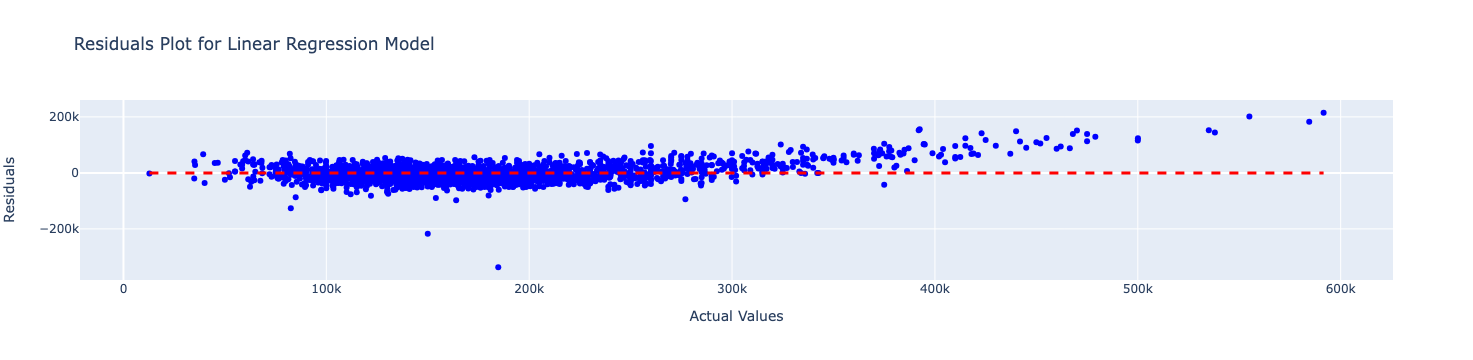

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     1275.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:24:23   Log-Likelihood:                -30223.
No. Observations:                2571   AIC:                         6.047e+04
Df Residuals:                    2561   BIC:                         6.052e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.457e+06   7.31e+04    -19.941   

In [155]:
#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = ft_train['SalePrice']
y_array = y.values


# Perform linear regression using scikit-learn
model = LinearRegression()
model.fit(X, y)

X_with_intercept = sm.add_constant(X)  # Add intercept term
model_sm = sm.OLS(y,X_with_intercept).fit()

# Make predictions using the trained model
predictions = model.predict(X)


# Rsquared value
print("R Squared on the test set:", r2_score(y, predictions))


# Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y, predictions)
print("Mean Squared Error (MSE) on the test set:", mse)

# Root Mean Squared Error (RMSE) on the test set
rmse = mean_squared_error(y, predictions, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", rmse)



# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values
fig.add_trace(go.Scatter(x=y, y=predictions, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))
# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y), x1=max(y), y0=min(y), y1=max(y),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()


# Plotting residuals
residuals = y - predictions
fig2 = go.Figure()

# Add a scatter plot for actual values and residuals
fig2.add_trace(go.Scatter(x=y, y=residuals, mode='markers', marker=dict(color='blue'), 
                         name='Residuals'))

# Add a horizontal line at y=0 for reference
fig2.add_shape(type="line", x0=min(y), x1=max(y), y0=0, y1=0,
              line=dict(color="red", width=3, dash='dash'),
              name="Zero Residuals Line")


fig2.update_layout(title="Residuals Plot for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Residuals")

fig2.show()


# Using statsmodels to check p-values
print(model_sm.summary())
print('\n')

# Mean Squared Error (MSE)
mse = mean_squared_error(y, predictions)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y, predictions, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

print('\n')

print("F-statistic:", model_sm.fvalue)
print("F-statistic p-value:", model_sm.f_pvalue)

In [149]:
# qqplot(residuals, line='s')
# plt.title("QQ Plot")
# plt.show()

# Test Train Split Model

I was originally using the full dataset to train my model and test it on the same data. We will now look at how the results are from splitting the data.

R Squared on the test set: 0.8295090787840849
Mean Squared Error (MSE) on the test set: 831240004.6869078
Root Mean Squared Error (RMSE) on the test set: 28831.23314544329


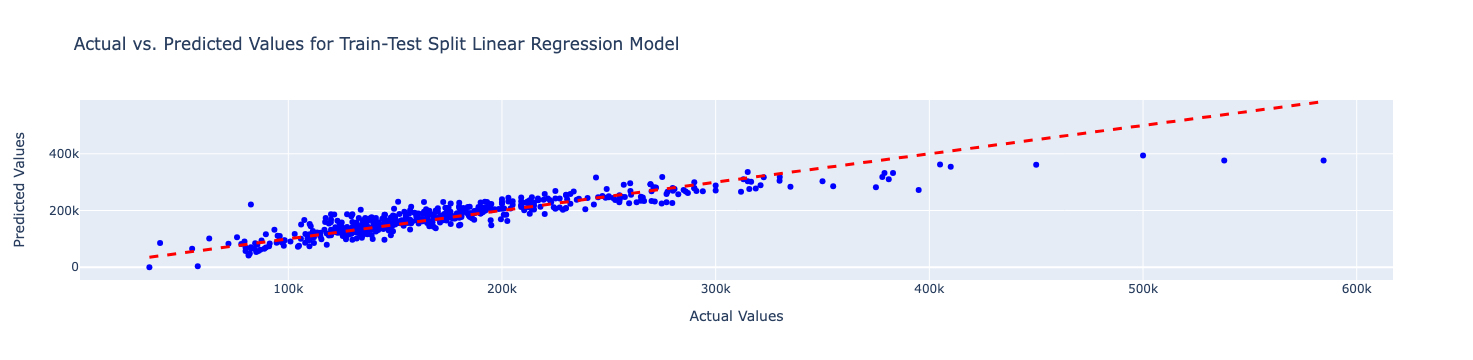

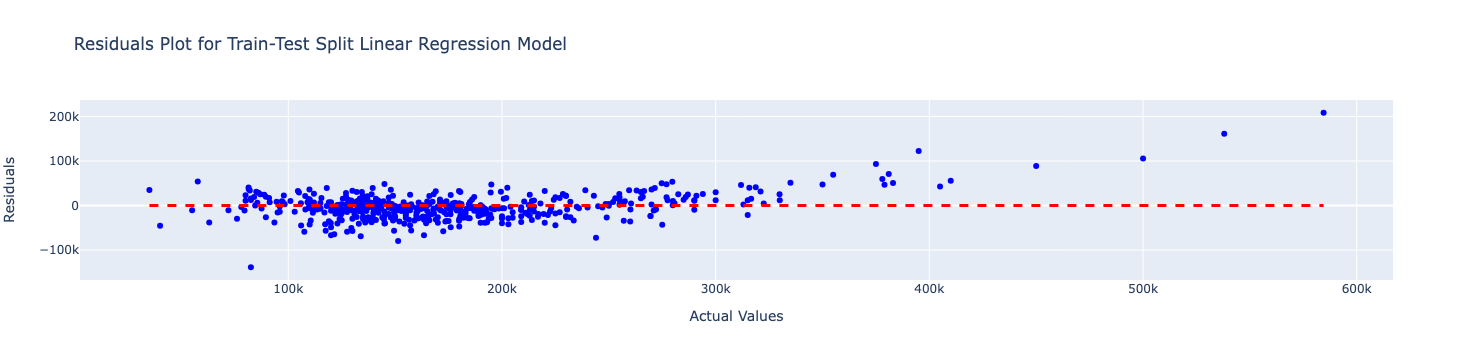

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Rsquared value
print("R Squared on the test set:", r2_score(y_test, predictions))


# Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE) on the test set:", mse)

# Root Mean Squared Error (RMSE) on the test set
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", rmse)


# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values on the test set
fig.add_trace(go.Scatter(x=y_test, y=predictions, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))
# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y_test), x1=max(y_test), y0=min(y_test), y1=max(y_test),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Train-Test Split Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()

# Plotting residuals
residuals = y_test - predictions
fig2 = go.Figure()

# Add a scatter plot for actual values and residuals on the test set
fig2.add_trace(go.Scatter(x=y_test, y=residuals, mode='markers', marker=dict(color='blue'), 
                         name='Residuals'))

# Add a horizontal line at y=0 for reference
fig2.add_shape(type="line", x0=min(y_test), x1=max(y_test), y0=0, y1=0,
              line=dict(color="red", width=3, dash='dash'),
              name="Zero Residuals Line")

fig2.update_layout(title="Residuals Plot for Train-Test Split Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Residuals")

fig2.show()

print('\n')


# K-Fold Multiple Linear Regression

In [263]:

#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
#the target (dependent variable) will be y
y = ft_train['SalePrice']

# Create a linear regression model
model = LinearRegression()

# Specify the number of folds for K-Fold Cross-Validation
num_folds = 5 # You can adjust this number based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}")


Cross-Validation Scores: [0.82950908 0.78424971 0.84782002 0.84905795 0.86315313] 

Mean R^2: 0.8347579778296412 

Standard Deviation R^2: 0.027422719284156124


In [152]:
# Create a Lasso regression model


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha = 0.1  # Regularization strength (adjust as needed)
lasso_model = Lasso(alpha=alpha)

# Fit the Lasso model on the training set
lasso_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
lasso_y_pred = lasso_model.predict(X_test_scaled)

# Evaluate the model
lasso_mse = mean_squared_error(y_test, lasso_y_pred)
lasso_r2 = r2_score(y_test, lasso_y_pred)
print(f'R-squared on the test set: {lasso_r2}')
print(f'Mean Squared Error on the test set: {lasso_mse}')
# Root Mean Squared Error (RMSE) on the test set
lasso_rmse = mean_squared_error(y_test, lasso_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", lasso_rmse)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
print('\nCoefficients:')
print(coefficients)

R-squared on the test set: 0.5514968671164892
Mean Squared Error on the test set: 2186707325.06653
Root Mean Squared Error (RMSE) on the test set: 46762.2425153727

Coefficients:
            Feature   Coefficient
0         GrLivArea  52307.462386
1        MSSubClass  -9082.402604
2  Condition2_Feedr  -2290.556016
3   Condition2_Norm   1073.722653
4   Condition2_PosA   3748.771308
5   Condition2_PosN    137.819222
6   Condition2_RRAe      0.000000
7   Condition2_RRAn   -992.034917
8   Condition2_RRNn    321.170162


In [153]:
# Create a Ridge regression model


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha = 0.1  # Regularization strength (adjust as needed)
ridge_model = Ridge(alpha=alpha)

# Fit the Lasso model on the training set
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
ridge_y_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)
print(f'R-squared on the test set: {ridge_r2}')
print(f'Mean Squared Error on the test set: {ridge_mse}')
# Root Mean Squared Error (RMSE) on the test set
ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", ridge_rmse)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
print('\nCoefficients:')
print(coefficients)

R-squared on the test set: 0.5514974745975104
Mean Squared Error on the test set: 2186704363.25177
Root Mean Squared Error (RMSE) on the test set: 46762.21084649196

Coefficients:
            Feature   Coefficient
0         GrLivArea  52307.462386
1        MSSubClass  -9082.402604
2  Condition2_Feedr  -2290.556016
3   Condition2_Norm   1073.722653
4   Condition2_PosA   3748.771308
5   Condition2_PosN    137.819222
6   Condition2_RRAe      0.000000
7   Condition2_RRAn   -992.034917
8   Condition2_RRNn    321.170162
